## Задание 4.
Рассмотрим датасет по предсказанию года создания песни по числовым признакам.
Информацию о датасете можно найти здесь: 
- https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD#
- http://labrosa.ee.columbia.edu/millionsong
- https://en.wikipedia.org/wiki/Timbre

**Ссылка**: https://www.kaggle.com/t/c55b0b2354bd4ca5ac83fe5ed8b3eb92

Мы используем поднабор этого датасета. Пожалуйста, не используйте исходный датасет для читинга, за это получите 0 за ВООБЩЕ всю домашку. Это задание организовано с помощью соревнования на kaggle.
Попробуйте обучить нейронную сеть (используя линейные и другие слои, возможную нормализацию и активации). Можете использовать любые методы предобработки данных и фокусы, 
кроме ансамблирования и использования сторонних источников ДАННЫХ.
- Задание обязательно, базовое максимальное число баллов - 6. 
- Топ 25% получат +3 балла, топ 50 +2 балла, топ 75 +1 балл.
- Решение должно быть уникальным, необходимо предоставить код и описание решения. Если использованы внешние источники (туториалы, статьи и т.п.), необходимо предоставить ссылки.
- Обучите модель, используя ваш кастомный оптимизатор. Это даст еще 1 балл. Покажите, изменилось ли что-то.
- При решении задачи можно использовать любые встренные в torch модули (nn, optim, transforms, etc)
- Можно использовать numpy, sklearn, pandas ТОЛЬКО для предобработки и постобработки решения (сборки сабмишена). Для самой модели можно использовать только torch.
- При переобучении можно добавить dropout, batchnorm итд. 

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


df_x = pd.read_csv("../../datasets/YearPredictionMSD/train_x.csv", index_col=[0]) #, sep=","
df_y = pd.read_csv("../../datasets/YearPredictionMSD/train_y.csv", index_col=[0])
df = pd.merge(df_x, df_y, left_index=True, right_index=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14000 entries, 133081 to 154731
Data columns (total 91 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       14000 non-null  float64
 1   1       14000 non-null  float64
 2   2       14000 non-null  float64
 3   3       14000 non-null  float64
 4   4       14000 non-null  float64
 5   5       14000 non-null  float64
 6   6       14000 non-null  float64
 7   7       14000 non-null  float64
 8   8       14000 non-null  float64
 9   9       14000 non-null  float64
 10  10      14000 non-null  float64
 11  11      14000 non-null  float64
 12  12      14000 non-null  float64
 13  13      14000 non-null  float64
 14  14      14000 non-null  float64
 15  15      14000 non-null  float64
 16  16      14000 non-null  float64
 17  17      14000 non-null  float64
 18  18      14000 non-null  float64
 19  19      14000 non-null  float64
 20  20      14000 non-null  float64
 21  21      14000 non-null  float64
 2

In [14]:
df.describe()
df.to_csv("df_describe()", sep='\t', index = False)


In [15]:
corr_matrix = df.corr()
corr_matrix

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,year
0,1.000000,0.566384,0.238219,0.015581,-0.290998,-0.255993,0.150465,-0.056922,0.218639,0.100482,...,0.185610,-0.141162,0.043386,0.131090,-0.023281,0.060050,-0.151631,-0.090429,-0.181318,0.231402
1,0.566384,1.000000,0.003449,0.108685,-0.176475,-0.118153,0.093488,0.110959,0.139684,0.381411,...,0.068017,-0.160104,0.025871,0.147906,0.052706,0.001514,-0.020335,-0.117093,-0.143765,0.027011
2,0.238219,0.003449,1.000000,0.141888,-0.120211,0.058324,-0.056112,0.084467,0.032342,-0.103261,...,0.176158,0.105282,-0.013705,-0.038581,-0.103733,0.083694,-0.078674,-0.090521,0.096694,-0.142195
3,0.015581,0.108685,0.141888,1.000000,0.041031,0.316875,0.276893,0.033091,-0.068800,0.158218,...,-0.103787,0.064347,0.081510,-0.082989,0.065558,0.024398,0.263893,0.042521,0.004551,0.015034
4,-0.290998,-0.176475,-0.120211,0.041031,1.000000,0.012747,-0.099421,-0.004039,-0.218758,-0.090853,...,-0.094841,0.025572,-0.023188,0.013525,0.001245,-0.029810,-0.015504,-0.009246,0.031752,0.005840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,0.060050,0.001514,0.083694,0.024398,-0.029810,-0.030335,0.024270,0.020748,0.057749,0.021375,...,-0.015066,0.160687,0.360869,0.020517,0.015611,1.000000,-0.016337,0.182361,0.216426,0.021897
87,-0.151631,-0.020335,-0.078674,0.263893,-0.015504,0.137150,0.087998,0.047344,0.003349,0.068824,...,0.002216,0.267372,0.008950,-0.233718,0.091228,-0.016337,1.000000,0.058742,0.228683,-0.017512
88,-0.090429,-0.117093,-0.090521,0.042521,-0.009246,-0.003068,0.091808,-0.010945,0.024786,-0.021552,...,-0.064811,0.077995,0.127760,-0.017652,0.180202,0.182361,0.058742,1.000000,0.168630,0.005741
89,-0.181318,-0.143765,0.096694,0.004551,0.031752,0.019502,-0.067506,0.059553,0.048917,0.016578,...,-0.019252,0.090612,-0.029815,-0.155303,-0.025547,0.216426,0.228683,0.168630,1.000000,-0.050458


In [16]:
#plt.figure(figsize=(15,6))
#sns.heatmap(corr_matrix, square=True, annot=True)

Text(0, 0.5, 'Number of songs')

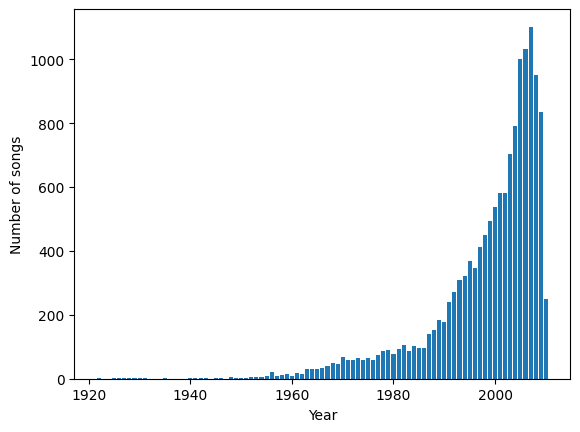

In [17]:
nsongs = {}
for y in range(1922,2012):
    nsongs[y] = len(df[df.year==y])
yrs = range(1922,2011)
values = [nsongs[y] for y in yrs]
plt.bar(yrs, values, align='center')
plt.xlabel("Year")
plt.ylabel("Number of songs")

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(df.iloc[:, 0:90], df_y["year"], test_size=0.3)
X_train

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
264631,41.95455,2.79587,28.70914,8.33537,-15.71706,-4.64958,7.83141,-5.48388,5.70127,-3.88782,...,39.35482,-55.54915,-24.12397,17.50912,7.01392,103.15534,-19.17140,-2.70596,30.51853,-9.12092
386263,48.08403,55.03702,12.06707,-9.39936,-46.88225,-17.09339,-0.09902,-3.37511,14.37080,10.07093,...,-63.73690,-171.56423,39.97300,28.41546,11.33718,118.55980,20.64569,14.33212,-84.70491,-5.56223
274126,38.97278,14.60394,40.31790,-11.84995,22.74919,-17.34193,-15.20389,-4.79462,4.04162,-3.50223,...,22.93372,-110.27086,60.77251,95.25589,15.96727,46.14618,178.08514,-3.76049,398.95786,3.60206
249892,29.85642,-182.93177,-22.48609,-39.67730,64.62685,-45.84061,-2.42885,3.51331,-2.52299,-4.97194,...,-14.56730,69.03584,7.86352,-49.69717,-10.60354,-47.79281,-166.96756,3.21395,-76.40200,-1.91996
442300,39.54550,26.23454,1.19239,20.73990,-5.15503,-7.62071,-20.57196,-19.61369,15.35122,10.80144,...,-0.75755,-171.03827,-86.94504,-21.00944,-8.28057,-77.18747,-128.91267,-7.96382,-191.31605,-16.20579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241213,45.05072,-1.73809,-2.80596,-3.07236,-17.90094,-10.55004,-9.88829,-0.30302,3.47304,2.28339,...,59.92943,-140.11555,9.21801,80.28691,7.25729,-162.34256,5.47290,-27.31239,-188.01094,-23.16869
107234,50.99914,56.83252,10.03297,-8.40466,-21.94616,-26.34287,-9.87774,-1.54800,12.26215,10.63433,...,-8.18647,-20.01698,23.09171,62.06364,-5.04850,22.70568,62.24701,0.32390,-71.20491,1.06230
17109,29.73429,-81.19216,13.55783,-11.24228,41.65114,9.50686,-18.54815,13.94388,-15.56793,-0.62238,...,58.01401,-519.60086,99.48418,94.22962,-44.17620,184.29821,24.42352,-10.98333,-233.21722,4.40895
511527,50.75285,22.57614,17.33451,-5.96454,-28.88097,-15.58404,4.21988,0.64604,5.02710,4.66471,...,-21.39589,14.96884,-18.95478,16.15904,4.90613,-10.51609,-26.59625,-5.28068,-62.83083,-3.86130


In [19]:
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train)
# Apply transform to both the train set and the test set.
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
X_train_std = pd.DataFrame(X_train_std,columns=X_train.columns)


In [20]:
# Make an instance of the Model
pca = PCA(.90)

# We fit to only our training set
pca.fit(X_train_std)
# Print number of components generated
pca.n_components_

55

In [21]:
X_train_proc = pca.transform(X_train_std)
X_test_proc = pca.transform(X_test_std)

/home/dima/Документы/Першин_Никольская_Нейронные_сети/myvenv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [22]:
Y_train_proc = Y_train - min(Y_train)
Y_test_proc = Y_test - min(Y_test)

In [23]:
Y_train_hot = to_categorical(Y_train_proc, 90)
Y_test_hot = to_categorical(Y_test_proc, 90)

In [24]:
print(X_train_proc.shape)
print(Y_test_hot.shape)

(9800, 55)
(4200, 90)
